In [3]:
import os
import cv2
import math
import dlib
import PIL
import operator
import datetime
import itertools
import statistics
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from imutils import face_utils
from sklearn.svm import SVC

In [1]:
import os
import cv2
import math
import dlib
import operator
import datetime
import itertools
import statistics
import matplotlib
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.svm import SVC

# Declaration of functions
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))

def average(l): 
    return sum(l)/len(l)

# Declaration of variables
image_list = {}

pos_features = []
neg_features = []
labels = []

image_dir_pos = 'slike/positive'
image_dir_neg = 'slike/negative'

nbins = 9 # broj binova (unutar histograma ima 9 elemenata)
cell_size = (8, 8) # broj piksela po celiji
block_size = (3, 3) # broj celija po bloku

pos_imgs = []
neg_imgs = []

print('\n*** An algorithm that inserts HOG image features in SVM and KNN for \'stupid\' detection of drug addicts ***')
start_time = datetime.datetime.utcnow()
print('\nProcess started at ', start_time,'\n')

# Algorithm 1: Download all images from the folder
for img_name in os.listdir(image_dir_pos):
    img_path = os.path.join(image_dir_pos, img_name)
    img = load_image(img_path)
    img = cv2.resize(img,(50,25))
    pos_imgs.append(img)

for img_name in os.listdir(image_dir_neg):
    img_path = os.path.join(image_dir_neg, img_name)
    img = load_image(img_path)
    img = cv2.resize(img,(50,25))
    neg_imgs.append(img)

hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1], 
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)


# Algorithm 2: Calculating HOG image features and filling lists
for img in pos_imgs:
    pos_features.append(hog.compute(img))
    labels.append(1)

for img in neg_imgs:
    neg_features.append(hog.compute(img))
    labels.append(0)

# Algorithm 3: Preparation for classification
pos_features = np.array(pos_features)
neg_features = np.array(neg_features)
x = np.vstack((pos_features, neg_features))
y = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = reshape_data(x_train)
x_test = reshape_data(x_test)

end_prep_time = datetime.datetime.utcnow()

# Algorithm 4: SVM classification
start_svm_time = datetime.datetime.utcnow()
svm = SVC(kernel='linear', probability=True) 
svm.fit(x_train, y_train)
y_train_pred = svm.predict(x_train)
y_test_pred = svm.predict(x_test)
print("\nSVM Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("SVM Validation accuracy: ", accuracy_score(y_test, y_test_pred))
end_svm_time = datetime.datetime.utcnow()


# Algorithm 5: KNN classification
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(x_train, y_train)
y_train_pred = knn.predict(x_train)
y_test_pred = knn.predict(x_test)
print("\nKNN Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("KNN Validation accuracy: ", accuracy_score(y_test, y_test_pred))
end_knn_time = datetime.datetime.utcnow()

# Algorithm 6: Deep learning
model = Sequential()
n_cols = x_train.shape[1]

model.add(Dense(250, activation='relu', input_shape=(n_cols,)))
model.add(Dense(250, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=3)
model.fit(x_train, y_train, validation_split=0.2, epochs=30, callbacks=[early_stopping_monitor])

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
print("\nDeep learning Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Deep learning Validation accuracy: ", accuracy_score(y_test, y_test_pred))


end_time = datetime.datetime.utcnow()
print('\nProcess ended at ', end_time)
print('The process lasted ', end_time-start_time)

print('\nThe preparation of images lasted ', end_prep_time-start_time)
print('The SVM classification of images lasted ', end_svm_time-start_svm_time)
print('The KNN classification of images lasted ', end_knn_time-end_svm_time)
print('Deep learning classification of images lasted ', end_time-end_knn_time)


time_array = []
avg_array = []

for j in range(1000):
    for i in range(20):
        x = x_train[i].reshape(1, -1)

        start_time = datetime.datetime.utcnow()
        y = svm.predict(x)
        end_time = datetime.datetime.utcnow()

        time = end_time-start_time
        time_array.append(time.microseconds)
        
    avg_array.append(average(time_array))

print('The classification for SVM lasted in average (ms)', str(average(avg_array)/1000))

time_array = []
avg_array = []

for j in range(1000):
    for i in range(20):
        x = x_train[i].reshape(1, -1)

        start_time = datetime.datetime.utcnow()
        y = knn.predict(x)
        end_time = datetime.datetime.utcnow()

        time = end_time-start_time
        time_array.append(time.microseconds)
        
    avg_array.append(average(time_array))

print('The classification for KNN lasted in average (ms)', str(average(avg_array)/1000))

time_array = []
avg_array = []

for j in range(1000):
    for i in range(20):
        x = x_train[i].reshape(1, -1)

        start_time = datetime.datetime.utcnow()
        y = model.predict(x)
        end_time = datetime.datetime.utcnow()

        time = end_time-start_time
        time_array.append(time.microseconds)
        
    avg_array.append(average(time_array))

print('The classification for Deep learning lasted in average (ms)', str(average(avg_array)/1000))




/home/student/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



*** An algorithm that inserts HOG image features in SVM and KNN for 'stupid' detection of drug addicts ***

Process started at  2019-08-18 08:42:16.828722 


SVM Train accuracy:  0.7710280373831776
SVM Validation accuracy:  0.5740740740740741

KNN Train accuracy:  0.7990654205607477
KNN Validation accuracy:  0.5740740740740741
Train on 171 samples, validate on 43 samples
Epoch 1/30
171/171 [==============================] - 4s 24ms/step - loss: 0.5205 - acc: 0.4795 - val_loss: 0.5349 - val_acc: 0.4651
Epoch 2/30
171/171 [==============================] - 1s 4ms/step - loss: 0.5205 - acc: 0.4795 - val_loss: 0.5349 - val_acc: 0.4651
Epoch 3/30
171/171 [==============================] - 1s 3ms/step - loss: 0.5205 - acc: 0.4795 - val_loss: 0.5349 - val_acc: 0.4651
Epoch 4/30
171/171 [==============================] - 1s 5ms/step - loss: 0.5205 - acc: 0.4795 - val_loss: 0.5349 - val_acc: 0.4651

Deep learning Train accuracy:  0.4766355140186916
Deep learning Validation accuracy:  0.5925925

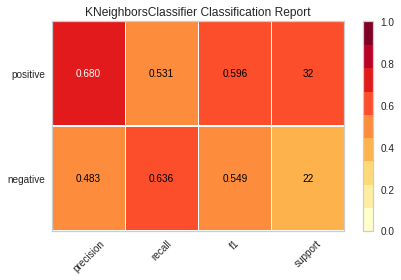

In [5]:
class_names = ['negative', 'positive']
visualizer = ClassificationReport(knn, classes = class_names, support = True)
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
g = visualizer.poof()

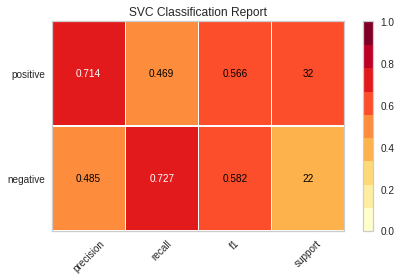

In [6]:
class_names = ['negative', 'positive']
visualizer = ClassificationReport(svm, classes = class_names, support = True)
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
g = visualizer.poof()